In [1]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([5.0, 6.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

Creating legend with loc="best" can be slow with large amounts of data.


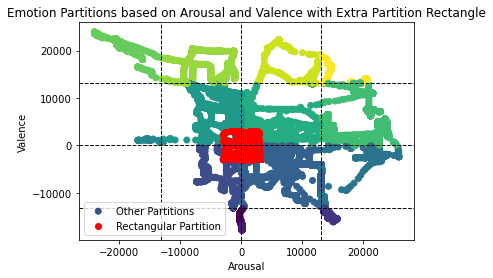

['Confident or Attentive' 'Passionate or Amused' 'Frustrated or Impatient'
 'Worried or Apathetic' 'Delighted or Happy' 'Tensed or Annoyed'
 'Pleased or Glad' 'Distressed or Defiant' 'Aroused or Astonished'
 'Relaxed or Calm' 'Tired or Bored' 'Excited or Adventurous'
 'Polite or Sleepy' 'Frustrated or Discontented']
        valence  arousal  video_x                 Emotion      ecg        bvp  \
4213     3373.0   -389.0      5.0  Confident or Attentive  0.76062  37.290980   
4214     3373.0   -389.0      5.0  Confident or Attentive  0.92490  34.733916   
4216     3897.0   -389.0      5.0  Confident or Attentive  0.71790  36.864803   
4217     3897.0   -389.0      5.0  Confident or Attentive  1.04974  35.092287   
4219     4493.0   -389.0      5.0  Confident or Attentive  0.75076  36.283673   
...         ...      ...      ...                     ...      ...        ...   
277054  10462.0 -11239.0      5.0  Confident or Attentive  0.82632  36.661384   
277055  10462.0 -11239.0      5.0 

In [3]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/relaxed_25-29_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/relaxed_25-29_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





TIME to interpret

 234.76904463768005 seconds


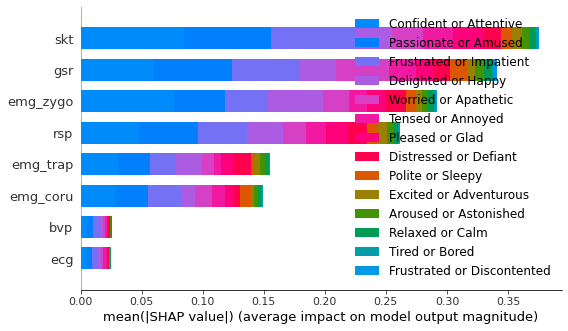

In [4]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


In [23]:
len(y_test)

18422

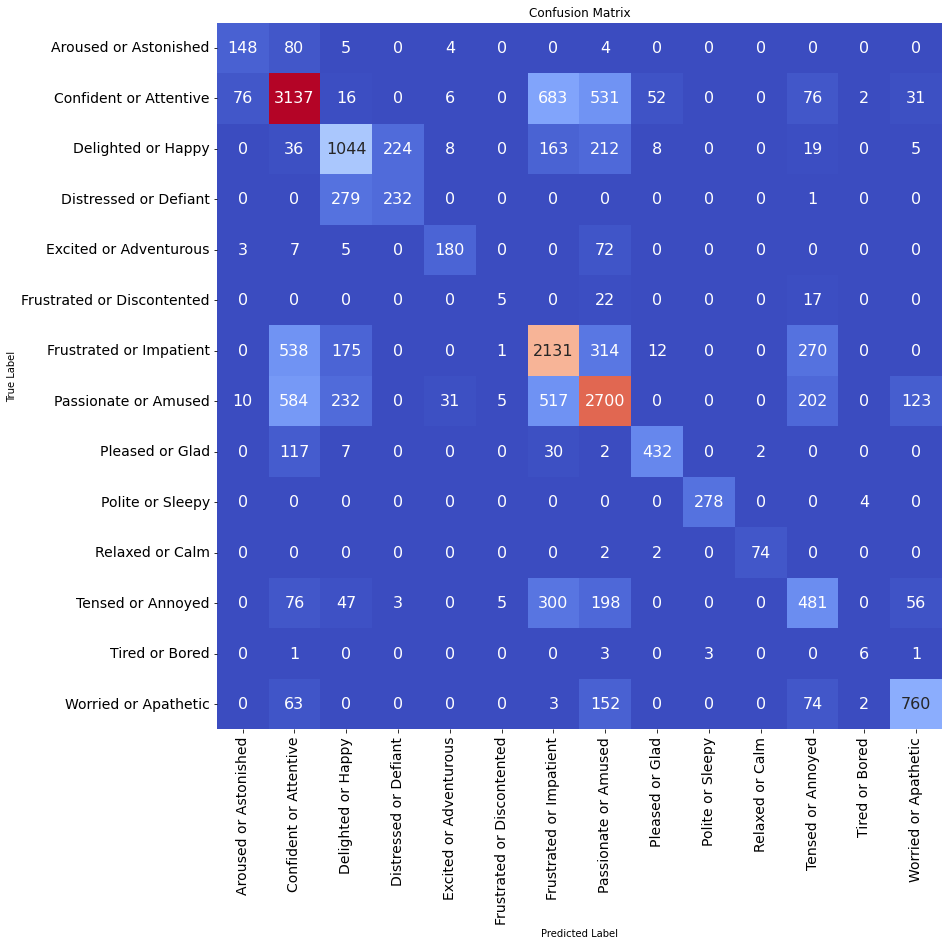

<Figure size 432x288 with 0 Axes>

In [6]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.630116165454348


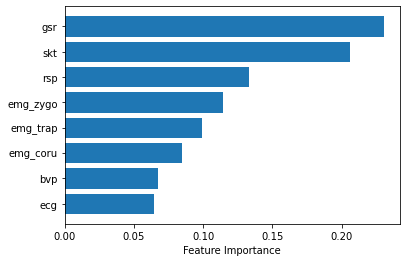

In [7]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [24]:
len(X_test)

18422

In [26]:
instance_index = 99
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.773760
bvp         37.397524
gsr         50.146032
rsp         47.346493
skt         30.479705
emg_zygo     6.220250
emg_coru    12.544750
emg_trap     5.604250
Name: 254553, dtype: float64
Passionate or Amused
Aroused or Astonished
[-0.00105788  0.00019444 -0.01241826 -0.00923691 -0.00176812  0.00725736
  0.00946191 -0.00319985]
Confident or Attentive
[-0.00050174  0.00230229 -0.08864732 -0.03520288 -0.06547027 -0.06910488
  0.01314969 -0.01127368]
Delighted or Happy
[ 0.00043119 -0.00073574 -0.01446405 -0.02471473 -0.02116715 -0.00294616
 -0.00218403 -0.02419436]
Distressed or Defiant
[-4.45833340e-04 -2.45675131e-05 -6.31344157e-04 -1.00603889e-02
 -1.05435586e-02 -6.44931055e-03  9.00868870e-03 -5.61592001e-03]
Excited or Adventurous
[-0.000196    0.00039332 -0.00808473 -0.00355401  0.00243871  0.00080895
 -0.00222661 -0.00365855]
Frustrated or Discontented
[ 2.30361418e-04 -9.46345240e-05  1.39498199e-04 -1.47016724e-04
 -2.80403782e-03 -7.38918972e-04  1.20545311e-

In [9]:
colour_scheme = 'cool'

FOR  Aroused or Astonished


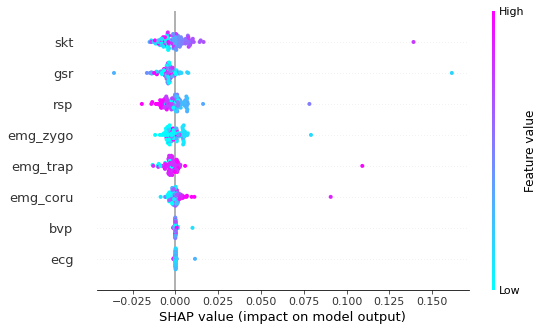

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


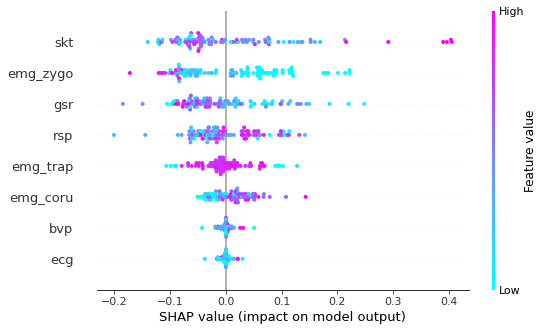

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


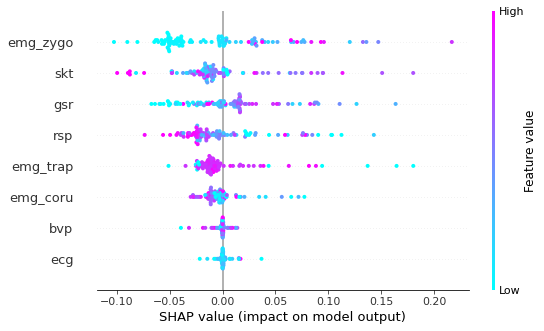

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


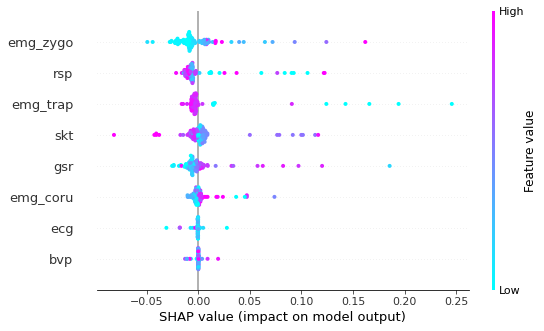

<Figure size 432x288 with 0 Axes>

FOR  Excited or Adventurous


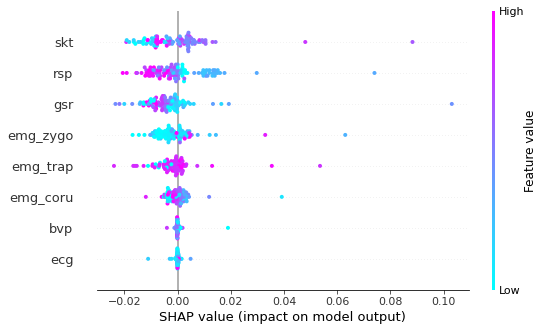

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


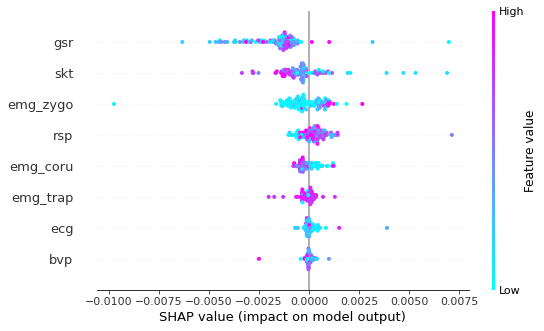

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


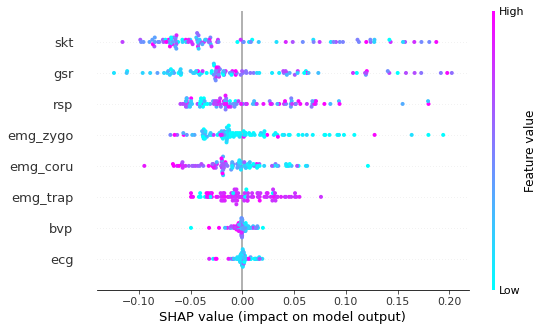

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


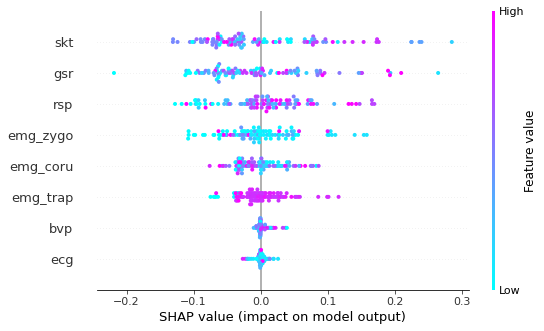

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


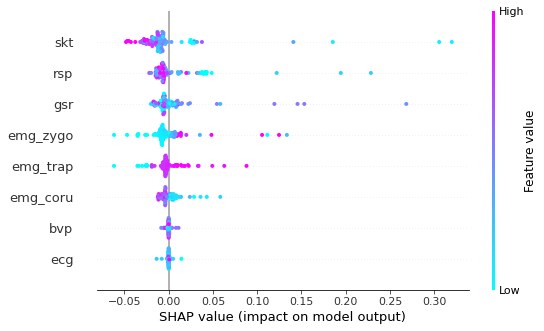

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


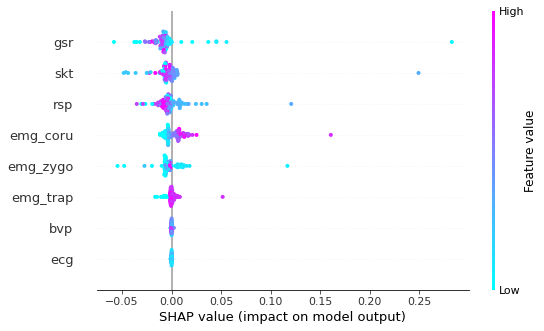

<Figure size 432x288 with 0 Axes>

FOR  Relaxed or Calm


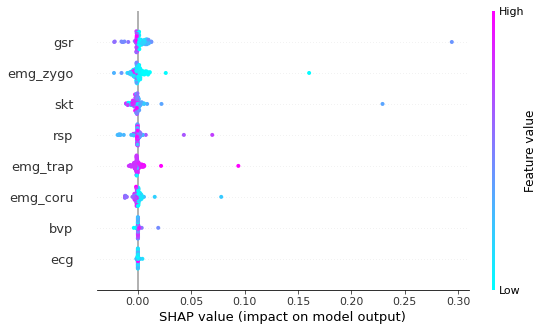

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


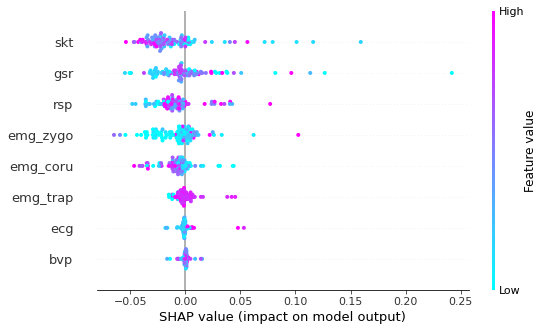

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


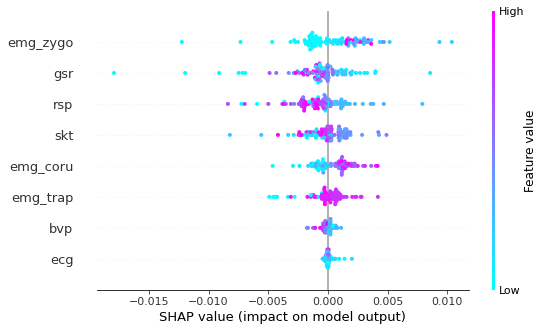

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


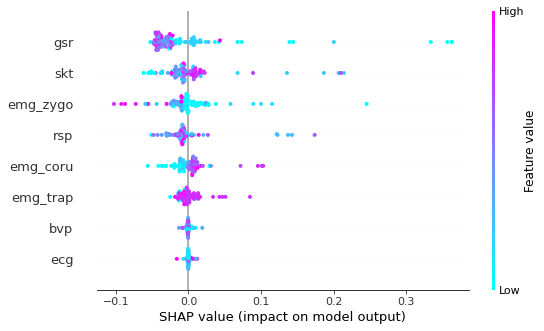

<Figure size 432x288 with 0 Axes>

In [10]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Aroused or Astonished


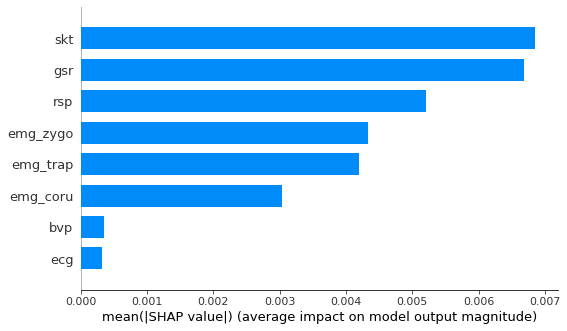

FOR  Confident or Attentive


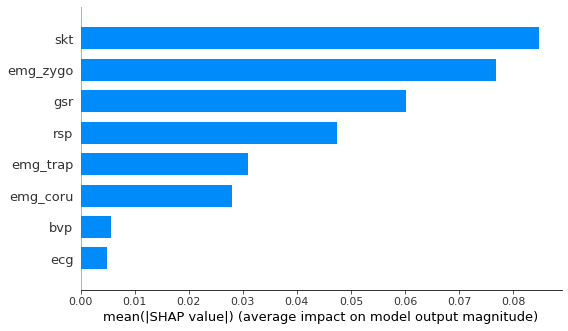

FOR  Delighted or Happy


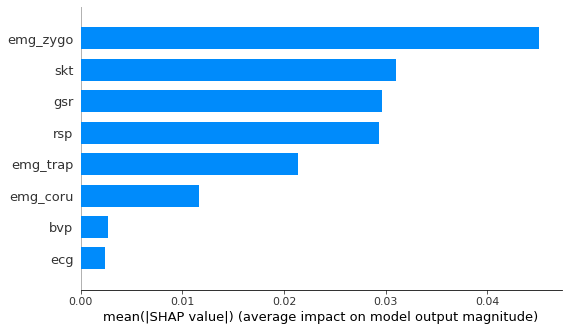

FOR  Distressed or Defiant


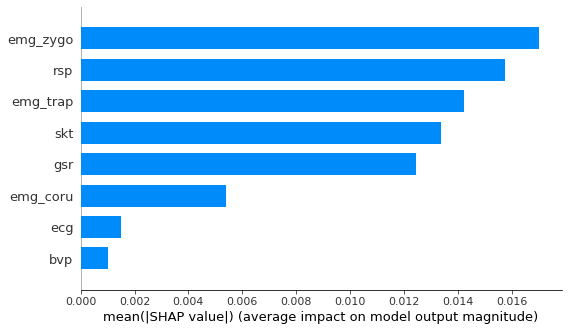

FOR  Excited or Adventurous


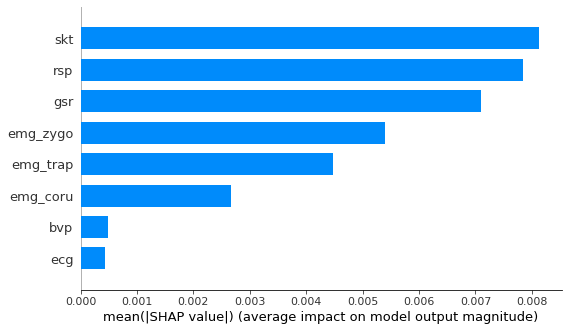

FOR  Frustrated or Discontented


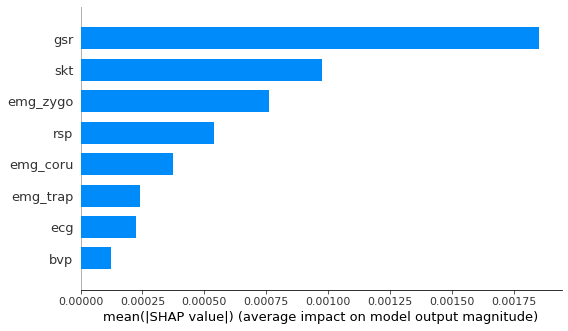

FOR  Frustrated or Impatient


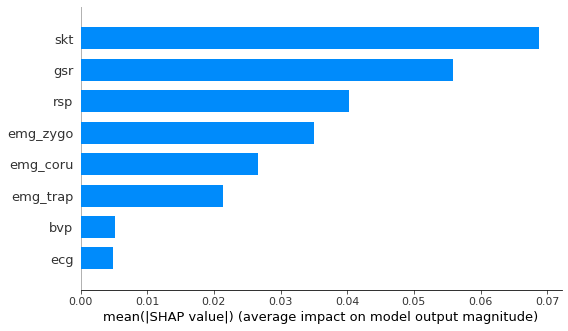

FOR  Passionate or Amused


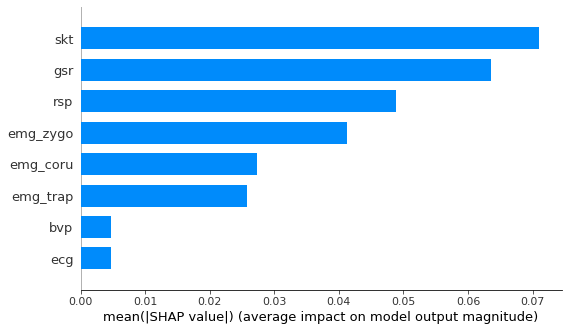

FOR  Pleased or Glad


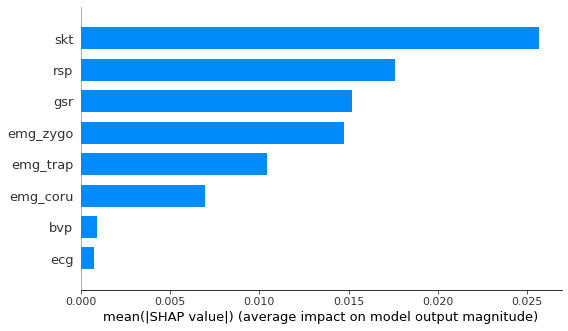

FOR  Polite or Sleepy


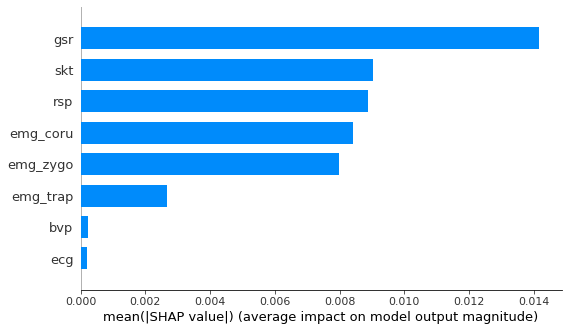

FOR  Relaxed or Calm


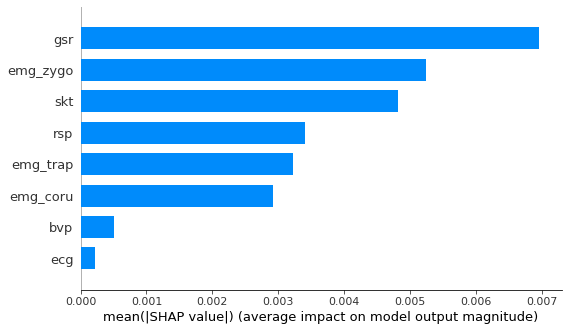

FOR  Tensed or Annoyed


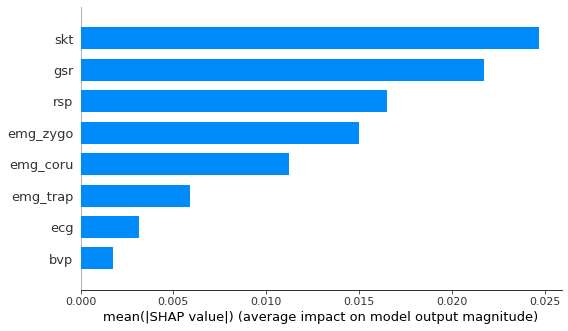

FOR  Tired or Bored


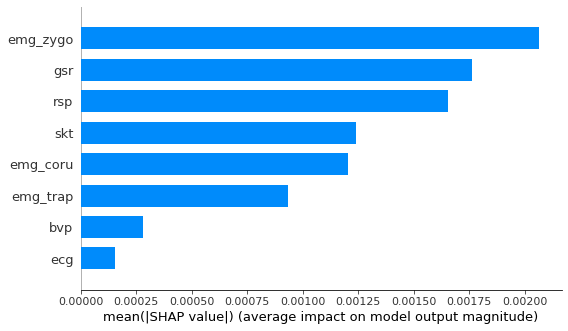

FOR  Worried or Apathetic


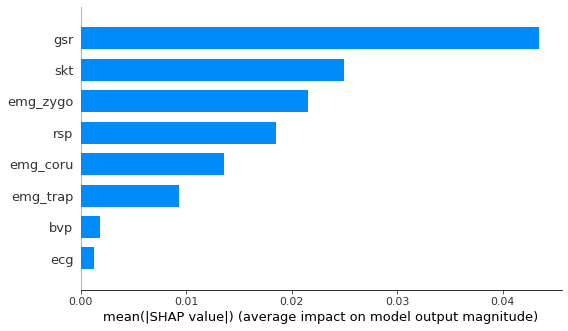

<Figure size 432x288 with 0 Axes>

In [11]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
shap.initjs()
from IPython.display import display
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.773760
bvp         37.397524
gsr         50.146032
rsp         47.346493
skt         30.479705
emg_zygo     6.220250
emg_coru    12.544750
emg_trap     5.604250
Name: 254553, dtype: float64
Passionate or Amused
CLASS  Aroused or Astonished


CLASS  Aroused or Astonished


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Excited or Adventurous


CLASS  Excited or Adventurous


In [13]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

11356.98097372055


In [14]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
31118   0.91504  34.414283  15.226440  33.011234  23.892379   4.70075   
28933   0.76718  38.337084  20.473992  35.334332  30.826774   5.15250   
199148  0.85262  37.755895  44.275440  46.339853  28.782904  24.74200   
63807   1.73968  34.956674  14.280240  36.805581  33.946914   4.82400   
119951  0.80332  36.341751  25.414032  41.422669  26.802160   4.74200   
...         ...        ...        ...        ...        ...       ...   
37355   0.69162  34.908267  15.033264  41.606568  27.619008   5.23475   
203951  0.51420  35.440988  39.213120  48.430617  28.260562  29.99875   
118205  0.82962  36.487092  25.004016  44.210375  26.844223   4.74200   
130461  0.74748  36.758258  20.572560  34.463156  30.805732   5.11150   
129121  1.01688  35.654077  32.613192  43.290823  25.732912   4.74200   

        emg_coru  emg_trap  
31118    6.01500  13.03775  
28933    9.38250   5.97400  
199148   5.23475   5.80975  
63807  

CLASS NAME  Aroused or Astonished


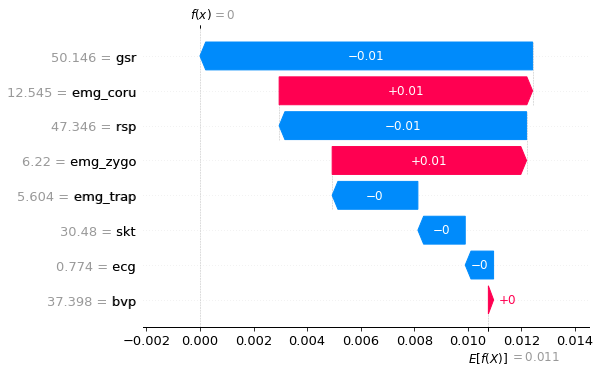

CLASS NAME  Confident or Attentive


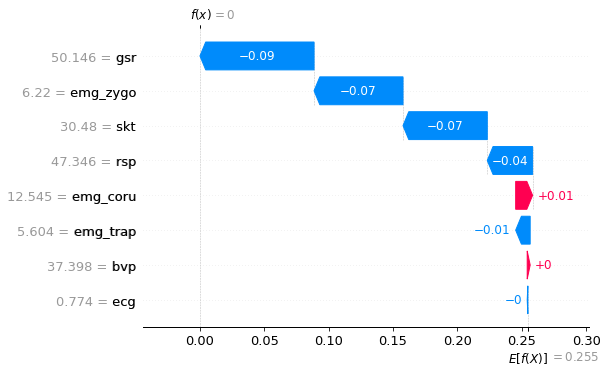

CLASS NAME  Delighted or Happy


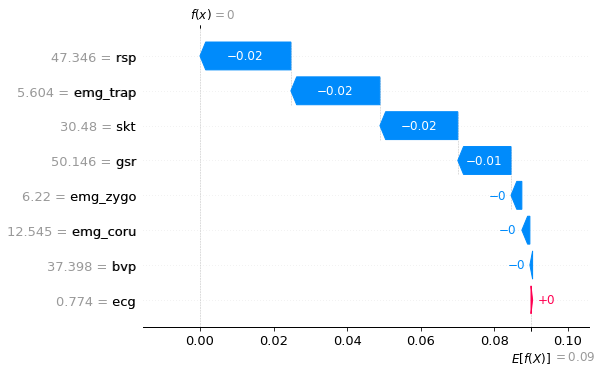

CLASS NAME  Distressed or Defiant


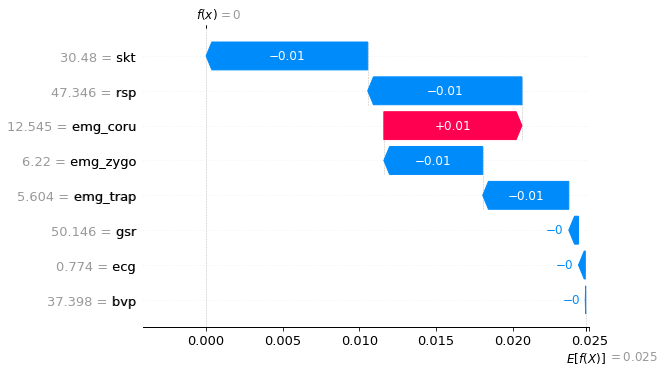

CLASS NAME  Excited or Adventurous


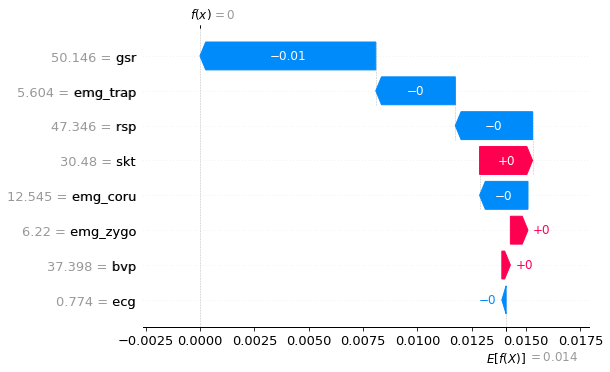

CLASS NAME  Frustrated or Discontented


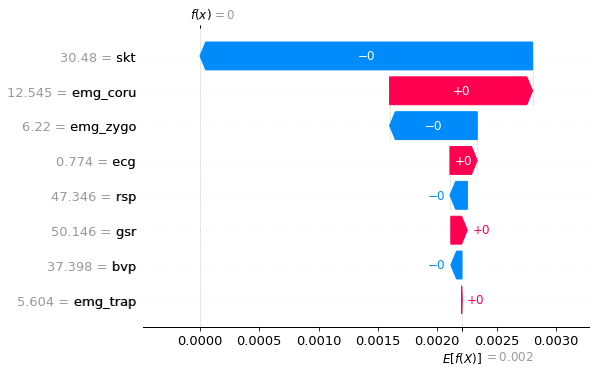

CLASS NAME  Frustrated or Impatient


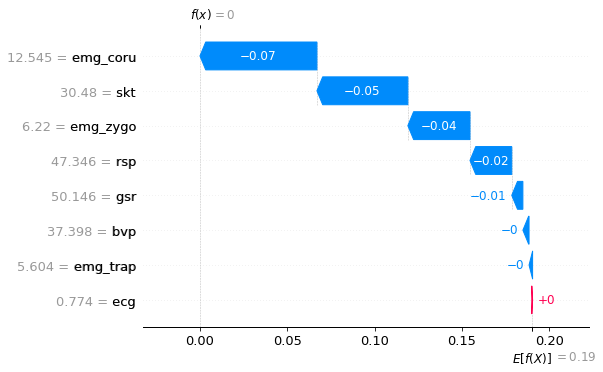

CLASS NAME  Passionate or Amused


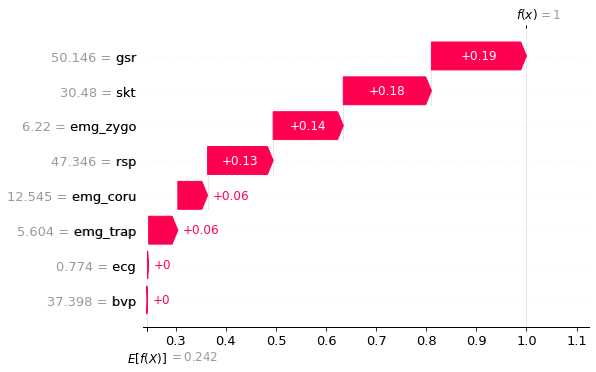

CLASS NAME  Pleased or Glad


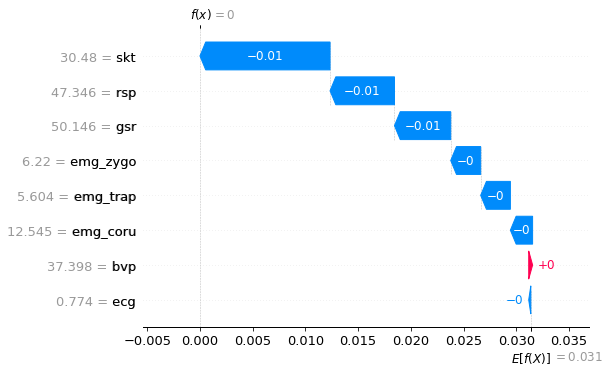

CLASS NAME  Polite or Sleepy


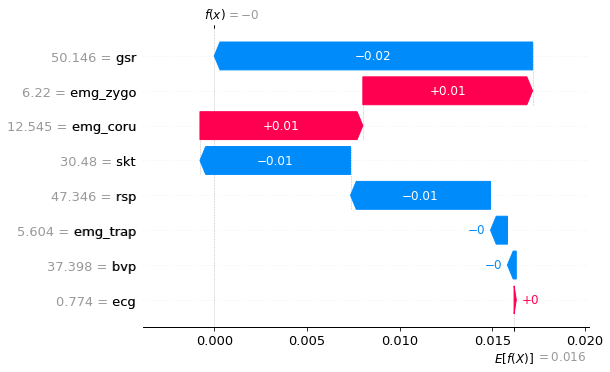

CLASS NAME  Relaxed or Calm


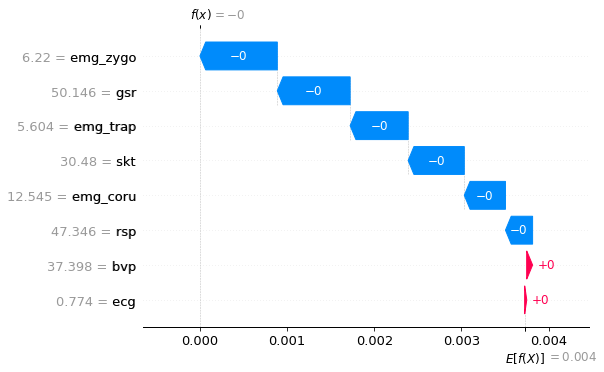

CLASS NAME  Tensed or Annoyed


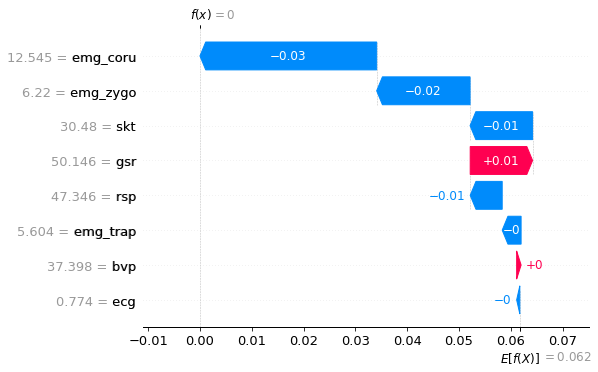

CLASS NAME  Tired or Bored


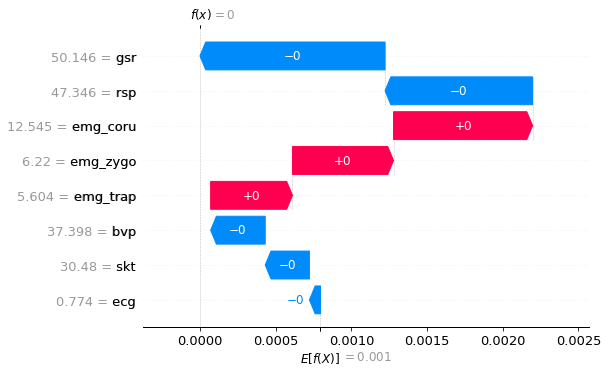

CLASS NAME  Worried or Apathetic


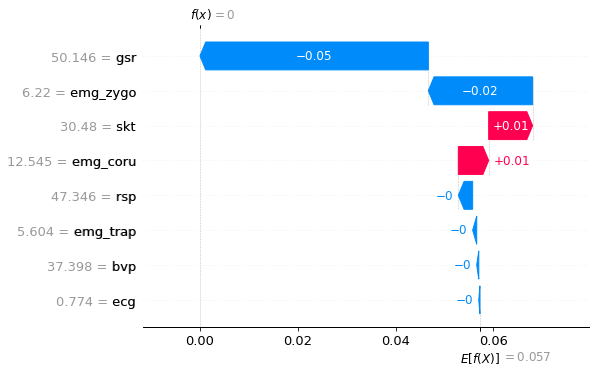

In [15]:
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [16]:
class_names[y_test[instance_index]]

'Passionate or Amused'

In [17]:
X_test.iloc[instance_index]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


ecg          0.773760
bvp         37.397524
gsr         50.146032
rsp         47.346493
skt         30.479705
emg_zygo     6.220250
emg_coru    12.544750
emg_trap     5.604250
Name: 254553, dtype: float64

CLASS  Aroused or Astonished


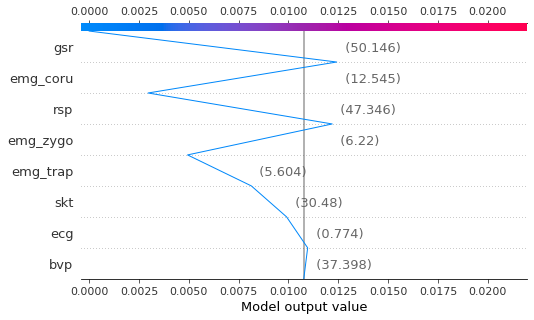

CLASS  Confident or Attentive


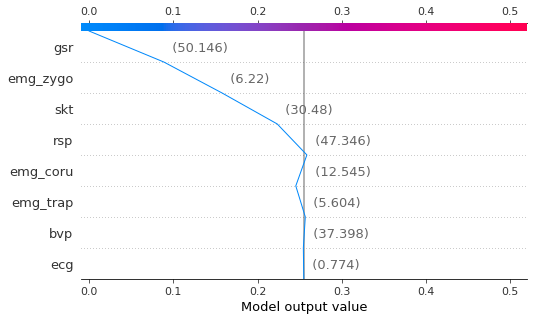

CLASS  Delighted or Happy


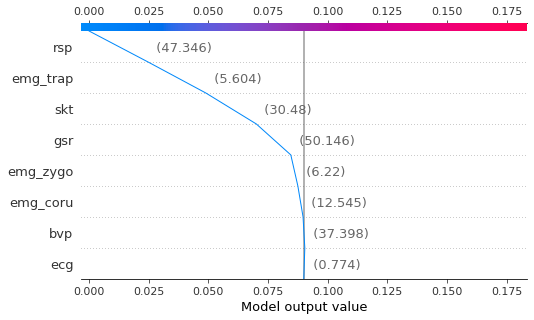

CLASS  Distressed or Defiant


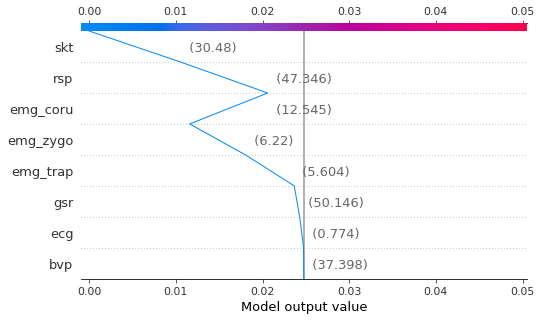

CLASS  Excited or Adventurous


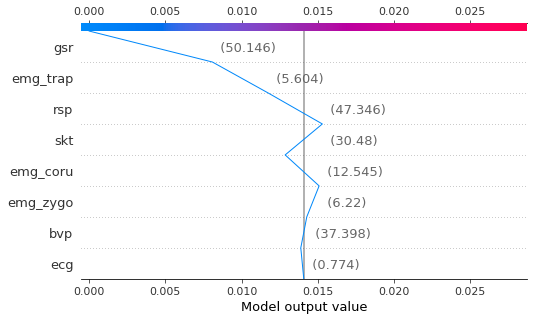

CLASS  Frustrated or Discontented


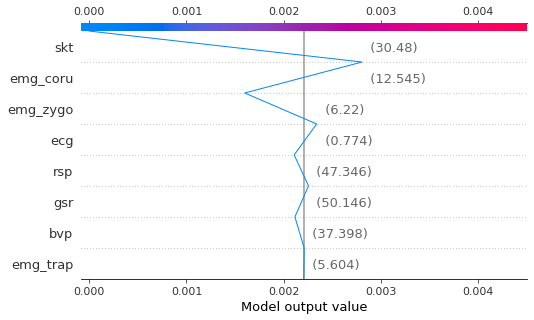

CLASS  Frustrated or Impatient


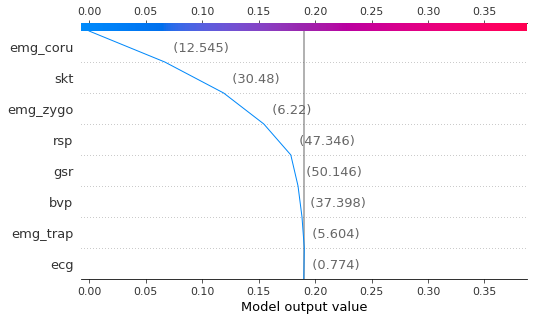

CLASS  Passionate or Amused


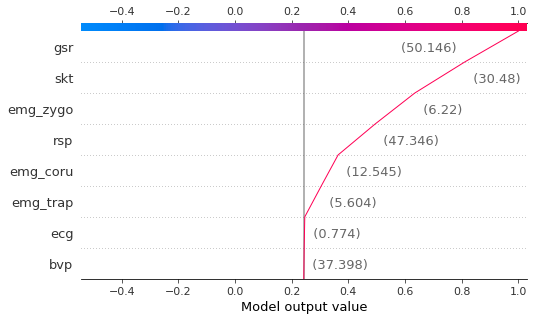

CLASS  Pleased or Glad


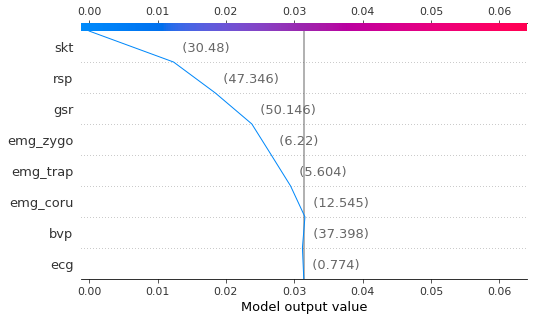

CLASS  Polite or Sleepy


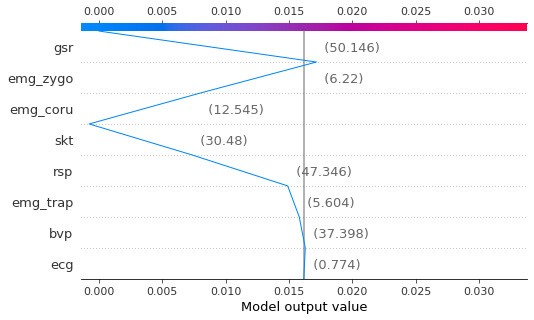

CLASS  Relaxed or Calm


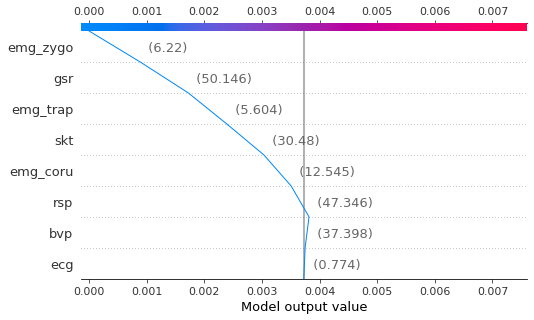

CLASS  Tensed or Annoyed


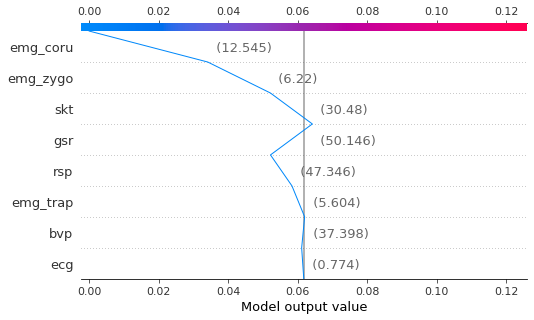

CLASS  Tired or Bored


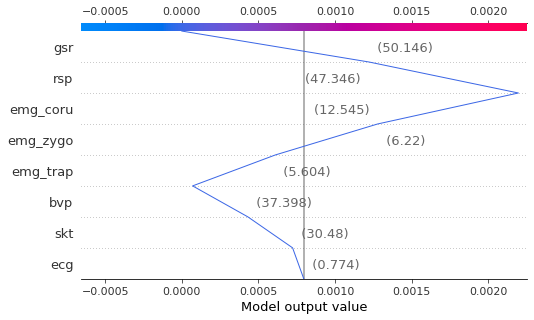

CLASS  Worried or Apathetic


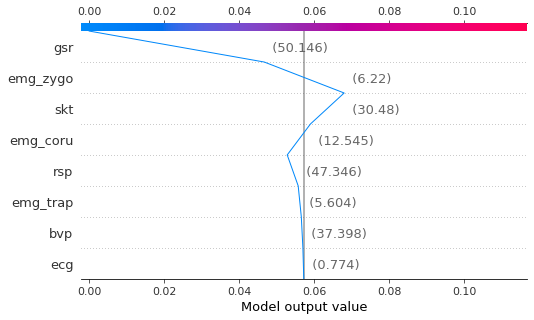

In [18]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 9.639249324798584 seconds


In [20]:
explanation = explanations_test[0]
explanation.show_in_notebook()

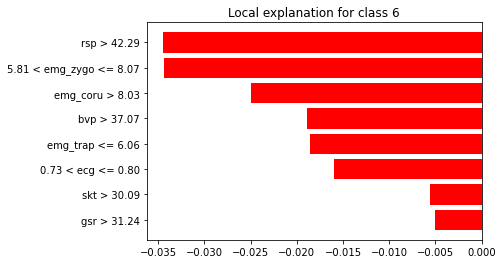

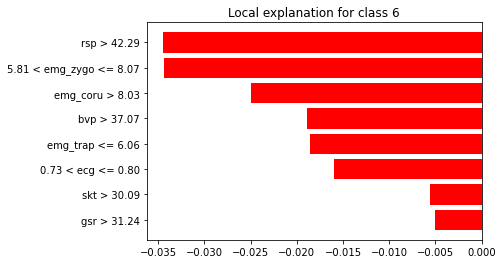

In [21]:
explanation.as_pyplot_figure(label=6)

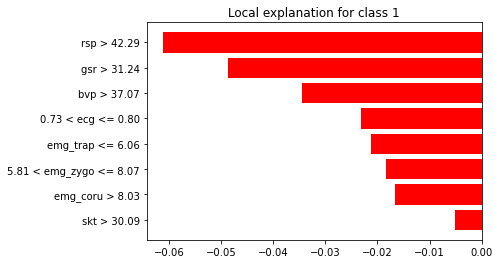

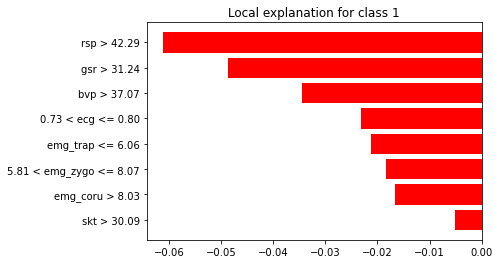

In [22]:
explanation.as_pyplot_figure(label=1)